# CIFAR10 with CNNs

Scores do modelo original:

 {'accuracy': 0.7136, 'balanced_accuracy': np.float64(0.7136000000000001), 'precision': 0.7141355730287995, 'recall': 0.7136, 'f1_score': 0.7133133029149751}

In [4]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

In [5]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,  transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,  transform=transform)

classes = test_dataset.classes

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


Gera val_dataset como subset balanceado de train_val_dataset


In [7]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [8]:
def makeLoaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Visualizar imagens

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

In [10]:
# Encontrar uma imagem de cada classe
images_per_class = {}
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(images_per_class) == len(classes):
        break

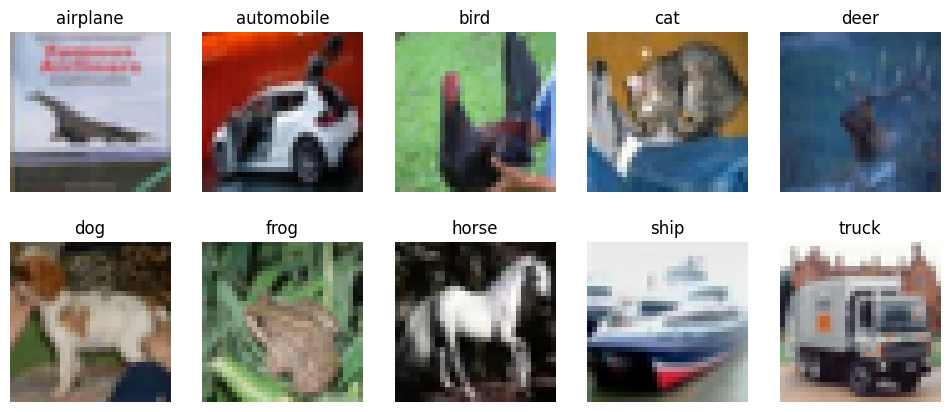

In [11]:
# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    ax.set_title(class_name)
    imshow(images_per_class[class_name])

plt.show()

### Defining the CNN model
Here we adapt the LeNet-5 architecture introduced in [*Gradient-based learning applied to document recognition*](https://ieeexplore.ieee.org/document/726791), originally developed to classify handwritten digits.

![lenet5](https://www.researchgate.net/publication/359784095/figure/fig2/AS:11431281079624737@1660789284522/Example-of-a-CNN-LeNet-5-14-is-able-to-identify-handwritten-digits-for-zip-code.png)


The main change we made here is the number of in/out channels, kernel sizes, padding, etc (enabling better results). It has 2 convolutional layers followed by 2 pooling (subsampling) layers. After the conv. blocks, we pass the feature maps through 2 hidden fully-connected layers to get the most activated neuron with the softmax function. If you want a more detailed explanation, [check this link](https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/) or reach us on Discord :)

In [12]:
class FlexibleCNN(nn.Module):
    """
    Uma classe de CNN flexível com entrada para imagens de 3 canais e 32x32 pixels.
    """
    def __init__(self, config):
        super(FlexibleCNN, self).__init__()
        self.config = config

        # Valores de entrada fixos
        initial_in_channels = 3
        img_height = 32
        img_width = 32

        # 1. Camadas de extração de características
        features_layers = []
        in_channels = initial_in_channels # Começa com o valor inicial

        for out_channels, k, s, p in self.config['conv_layers']:
            features_layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=k,
                    stride=s,
                    padding=p
                )
            )
            features_layers.append(nn.ReLU())
            if self.config.get('pool_kernel_size'):
                features_layers.append(
                    nn.MaxPool2d(
                        kernel_size=self.config['pool_kernel_size'],
                        stride=self.config.get('pool_stride', self.config['pool_kernel_size'])
                    )
                )
            in_channels = out_channels # Atualiza para a próxima camada do loop

        self.features = nn.Sequential(*features_layers)

        # 2. Calcular o tamanho da saída do extrator de features
        with torch.no_grad():
            dummy_input = torch.zeros(1, initial_in_channels, img_height, img_width)
            dummy_output = self.features(dummy_input)
            self.flattened_features_size = dummy_output.view(-1).shape[0]

        # 3. Construir o Classificador
        classifier_layers = []
        in_features = self.flattened_features_size

        for out_features, dropout_rate in self.config.get('fc_layers', []):
            classifier_layers.append(nn.Linear(in_features, out_features))
            classifier_layers.append(nn.ReLU())
            if dropout_rate > 0:
                classifier_layers.append(nn.Dropout(p=dropout_rate))
            in_features = out_features

        classifier_layers.append(nn.Linear(in_features, self.config['output_size']))
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        # O assert foi removido para simplificar, mas pode ser útil para debug
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Evaluation helper functions

In [13]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [14]:
def evaluate(net, loader, loss_function):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    net.train()
    return val_loss / len(loader)

In [15]:
#@title Evaluate model (accuracy, precision, recall, etc)

def makePredictions(net, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  net.eval()
  predictions = []
  labels = []
  for images, label in test_loader:
    images = images.to(device)
    label = label.to(device)

    output = net(images)
    _, predicted = torch.max(output,1)

    predictions.extend(predicted.cpu().numpy())
    labels.extend(label.cpu().numpy())

  return labels, predictions

In [16]:
def plotLoss(train_losses, val_losses):
    plt.plot(train_losses, label='Treinamento')
    plt.plot(val_losses, label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

## Train Loop

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=3):
    net.to(device)

    train_losses = []
    val_losses = []

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i + 1) % 1000 == 0:
              tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss:.4f}')

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validação
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        tqdm.write(f'Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch+1}")
                break

    # Restaura melhor modelo encontrado
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, val_losses

## Experiment 1

In [29]:
#@title Hyperparameters

learning_rate = 0.001
num_epochs = 50
batch_size = 32
patience = 5

In [30]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model1 = FlexibleCNN(config1)

In [ ]:
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

trained_CNN, train_losses, val_losses = train_model(model1,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:17<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.0847


  2%|▏         | 1/50 [00:26<21:27, 26.27s/it]

Epoch 1 completed. Train Loss: 1.3818 | Val Loss: 1.1235


  2%|▏         | 1/50 [00:43<21:27, 26.27s/it]

Epoch 2/50, Step 1000/1250, Loss: 0.6318


  4%|▍         | 2/50 [00:51<20:27, 25.57s/it]

Epoch 2 completed. Train Loss: 0.9913 | Val Loss: 0.9895


  4%|▍         | 2/50 [01:07<20:27, 25.57s/it]

Epoch 3/50, Step 1000/1250, Loss: 0.9587


  6%|▌         | 3/50 [01:16<19:50, 25.33s/it]

Epoch 3 completed. Train Loss: 0.8217 | Val Loss: 0.8844


  6%|▌         | 3/50 [01:33<19:50, 25.33s/it]

Epoch 4/50, Step 1000/1250, Loss: 0.4812


  8%|▊         | 4/50 [01:41<19:12, 25.05s/it]

Epoch 4 completed. Train Loss: 0.7038 | Val Loss: 0.8535


  8%|▊         | 4/50 [01:56<19:12, 25.05s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.7709


 10%|█         | 5/50 [02:05<18:35, 24.78s/it]

Epoch 5 completed. Train Loss: 0.5957 | Val Loss: 0.9403


 10%|█         | 5/50 [02:21<18:35, 24.78s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.7013


 12%|█▏        | 6/50 [02:30<18:10, 24.79s/it]

Epoch 6 completed. Train Loss: 0.5004 | Val Loss: 0.8795


 12%|█▏        | 6/50 [02:46<18:10, 24.79s/it]

Epoch 7/50, Step 1000/1250, Loss: 0.6888


 14%|█▍        | 7/50 [02:55<17:58, 25.07s/it]

Epoch 7 completed. Train Loss: 0.4138 | Val Loss: 0.9305


 14%|█▍        | 7/50 [03:12<17:58, 25.07s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.2996


 16%|█▌        | 8/50 [03:21<17:41, 25.27s/it]

Epoch 8 completed. Train Loss: 0.3401 | Val Loss: 1.0136


 16%|█▌        | 8/50 [03:38<17:41, 25.27s/it]

Epoch 9/50, Step 1000/1250, Loss: 0.1819


 16%|█▌        | 8/50 [03:47<19:54, 28.44s/it]

Epoch 9 completed. Train Loss: 0.2706 | Val Loss: 1.1412
Early stopping at epoch 9


## Experiment 1 results

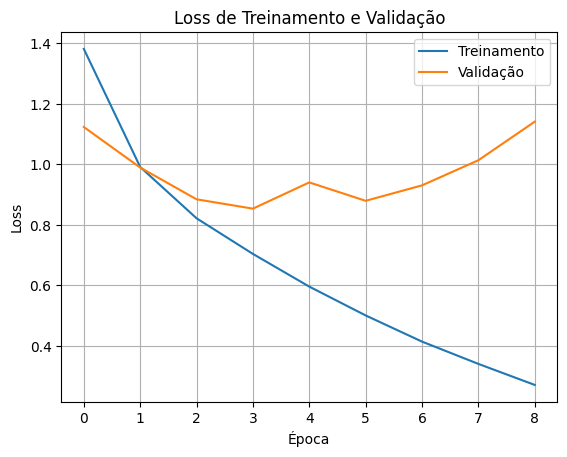

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
torch.save(model1.state_dict(), "model1_trained2.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = FlexibleCNN(config1)
model1.to(device)

model1.load_state_dict(torch.load("model1_trained.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
#@title Evaluate model (accuracy, precision, recall, etc)
labels, predictions = makePredictions(model1, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


Scores of your model
 {'accuracy': 0.6834, 'balanced_accuracy': 0.6834, 'precision': 0.6817896719656583, 'recall': 0.6834, 'f1_score': 0.6813534982457458}


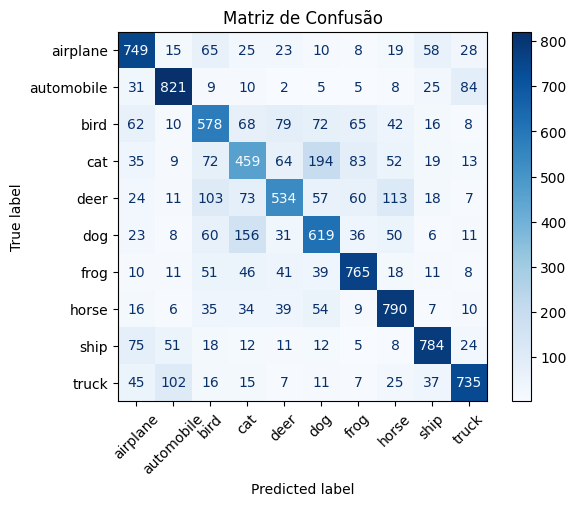

In [ ]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 2

Diminuir o learning rate

In [ ]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config1 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

# Criando o modelo
model2 = FlexibleCNN(config1)

optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
trained_CNN, train_losses, val_losses = train_model(model2,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:12<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.5811


  2%|▏         | 1/50 [00:17<14:33, 17.83s/it]

Epoch 1 completed. Train Loss: 1.7610 | Val Loss: 1.5436


  2%|▏         | 1/50 [00:29<14:33, 17.83s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.3359


  4%|▍         | 2/50 [00:34<13:49, 17.29s/it]

Epoch 2 completed. Train Loss: 1.4540 | Val Loss: 1.3899


  4%|▍         | 2/50 [00:45<13:49, 17.29s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.2491


  6%|▌         | 3/50 [00:51<13:23, 17.09s/it]

Epoch 3 completed. Train Loss: 1.3465 | Val Loss: 1.3112


  6%|▌         | 3/50 [01:03<13:23, 17.09s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.4880


  8%|▊         | 4/50 [01:08<13:06, 17.09s/it]

Epoch 4 completed. Train Loss: 1.2668 | Val Loss: 1.2551


  8%|▊         | 4/50 [01:19<13:06, 17.09s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.7146


 10%|█         | 5/50 [01:25<12:47, 17.05s/it]

Epoch 5 completed. Train Loss: 1.2023 | Val Loss: 1.1940


 10%|█         | 5/50 [01:37<12:47, 17.05s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.9474


 12%|█▏        | 6/50 [01:42<12:30, 17.05s/it]

Epoch 6 completed. Train Loss: 1.1465 | Val Loss: 1.1402


 12%|█▏        | 6/50 [01:54<12:30, 17.05s/it]

Epoch 7/50, Step 1000/1250, Loss: 0.8789


 14%|█▍        | 7/50 [01:59<12:15, 17.10s/it]

Epoch 7 completed. Train Loss: 1.0930 | Val Loss: 1.1132


 14%|█▍        | 7/50 [02:11<12:15, 17.10s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.9707


 16%|█▌        | 8/50 [02:16<11:54, 17.01s/it]

Epoch 8 completed. Train Loss: 1.0452 | Val Loss: 1.0843


 16%|█▌        | 8/50 [02:28<11:54, 17.01s/it]

Epoch 9/50, Step 1000/1250, Loss: 0.6057


 18%|█▊        | 9/50 [02:33<11:38, 17.03s/it]

Epoch 9 completed. Train Loss: 1.0034 | Val Loss: 1.0469


 18%|█▊        | 9/50 [02:45<11:38, 17.03s/it]

Epoch 10/50, Step 1000/1250, Loss: 1.3411


 20%|██        | 10/50 [02:50<11:21, 17.04s/it]

Epoch 10 completed. Train Loss: 0.9646 | Val Loss: 1.0307


 20%|██        | 10/50 [03:02<11:21, 17.04s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.9521


 22%|██▏       | 11/50 [03:07<11:02, 16.98s/it]

Epoch 11 completed. Train Loss: 0.9273 | Val Loss: 0.9976


 22%|██▏       | 11/50 [03:18<11:02, 16.98s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.6940


 24%|██▍       | 12/50 [03:24<10:44, 16.96s/it]

Epoch 12 completed. Train Loss: 0.8947 | Val Loss: 0.9962


 24%|██▍       | 12/50 [03:35<10:44, 16.96s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.7141


 26%|██▌       | 13/50 [03:41<10:26, 16.94s/it]

Epoch 13 completed. Train Loss: 0.8645 | Val Loss: 0.9651


 26%|██▌       | 13/50 [03:52<10:26, 16.94s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.6127


 28%|██▊       | 14/50 [03:58<10:10, 16.95s/it]

Epoch 14 completed. Train Loss: 0.8354 | Val Loss: 0.9561


 28%|██▊       | 14/50 [04:09<10:10, 16.95s/it]

Epoch 15/50, Step 1000/1250, Loss: 0.7730


 30%|███       | 15/50 [04:15<09:51, 16.91s/it]

Epoch 15 completed. Train Loss: 0.8086 | Val Loss: 0.9339


 30%|███       | 15/50 [04:26<09:51, 16.91s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.5296


 32%|███▏      | 16/50 [04:32<09:34, 16.89s/it]

Epoch 16 completed. Train Loss: 0.7838 | Val Loss: 0.9557


 32%|███▏      | 16/50 [04:43<09:34, 16.89s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.7410


 34%|███▍      | 17/50 [04:48<09:15, 16.85s/it]

Epoch 17 completed. Train Loss: 0.7591 | Val Loss: 0.9256


 34%|███▍      | 17/50 [05:00<09:15, 16.85s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.6086


 36%|███▌      | 18/50 [05:05<08:59, 16.86s/it]

Epoch 18 completed. Train Loss: 0.7353 | Val Loss: 0.9160


 36%|███▌      | 18/50 [05:17<08:59, 16.86s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.7741


 38%|███▊      | 19/50 [05:22<08:44, 16.90s/it]

Epoch 19 completed. Train Loss: 0.7118 | Val Loss: 0.9095


 38%|███▊      | 19/50 [05:34<08:44, 16.90s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.5819


 40%|████      | 20/50 [05:39<08:27, 16.93s/it]

Epoch 20 completed. Train Loss: 0.6885 | Val Loss: 0.9085


 40%|████      | 20/50 [05:50<08:27, 16.93s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.4198


 42%|████▏     | 21/50 [05:56<08:08, 16.84s/it]

Epoch 21 completed. Train Loss: 0.6658 | Val Loss: 0.9132


 42%|████▏     | 21/50 [06:07<08:08, 16.84s/it]

Epoch 22/50, Step 1000/1250, Loss: 0.7405


 44%|████▍     | 22/50 [06:13<07:51, 16.83s/it]

Epoch 22 completed. Train Loss: 0.6424 | Val Loss: 0.9077


 44%|████▍     | 22/50 [06:24<07:51, 16.83s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.5145


 46%|████▌     | 23/50 [06:29<07:33, 16.78s/it]

Epoch 23 completed. Train Loss: 0.6228 | Val Loss: 0.9235


 46%|████▌     | 23/50 [06:41<07:33, 16.78s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.8067


 48%|████▊     | 24/50 [06:46<07:15, 16.73s/it]

Epoch 24 completed. Train Loss: 0.6031 | Val Loss: 0.9059


 48%|████▊     | 24/50 [06:57<07:15, 16.73s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.7158


 50%|█████     | 25/50 [07:03<06:57, 16.69s/it]

Epoch 25 completed. Train Loss: 0.5804 | Val Loss: 0.9079


 50%|█████     | 25/50 [07:14<06:57, 16.69s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.5276


 52%|█████▏    | 26/50 [07:19<06:38, 16.61s/it]

Epoch 26 completed. Train Loss: 0.5591 | Val Loss: 0.9417


 52%|█████▏    | 26/50 [07:30<06:38, 16.61s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.4083


 54%|█████▍    | 27/50 [07:36<06:22, 16.63s/it]

Epoch 27 completed. Train Loss: 0.5400 | Val Loss: 0.9326


 54%|█████▍    | 27/50 [07:47<06:22, 16.63s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.5458


 56%|█████▌    | 28/50 [07:53<06:07, 16.71s/it]

Epoch 28 completed. Train Loss: 0.5194 | Val Loss: 0.9589


 56%|█████▌    | 28/50 [08:04<06:07, 16.71s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.6419


 56%|█████▌    | 28/50 [08:10<06:25, 17.51s/it]

Epoch 29 completed. Train Loss: 0.4981 | Val Loss: 0.9436
Early stopping at epoch 29


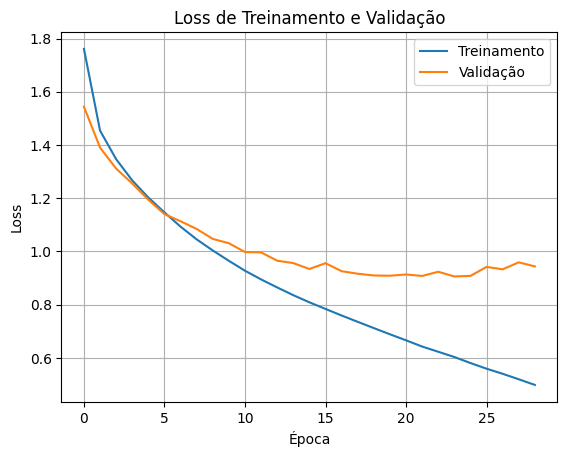

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6932, 'balanced_accuracy': 0.6931999999999999, 'precision': 0.6954373416965544, 'recall': 0.6932, 'f1_score': 0.6913819540778005}


## Experiment 3

Adicionar dropout para diminuir o overfitting

In [ ]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config2 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1),
        (128, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.2),
        (84, 0.2)
    ],
    'output_size': 10
}

# Criando o modelo
model3 = FlexibleCNN(config2)

optimizer = optim.Adam(model3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
trained_CNN, train_losses, val_losses = train_model(model3,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:16<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.8398


  2%|▏         | 1/50 [00:23<19:17, 23.62s/it]

Epoch 1 completed. Train Loss: 1.9058 | Val Loss: 1.6332


  2%|▏         | 1/50 [00:38<19:17, 23.62s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.5035


  4%|▍         | 2/50 [00:46<18:24, 23.02s/it]

Epoch 2 completed. Train Loss: 1.6013 | Val Loss: 1.4581


  4%|▍         | 2/50 [00:48<19:16, 24.09s/it]


KeyboardInterrupt: 

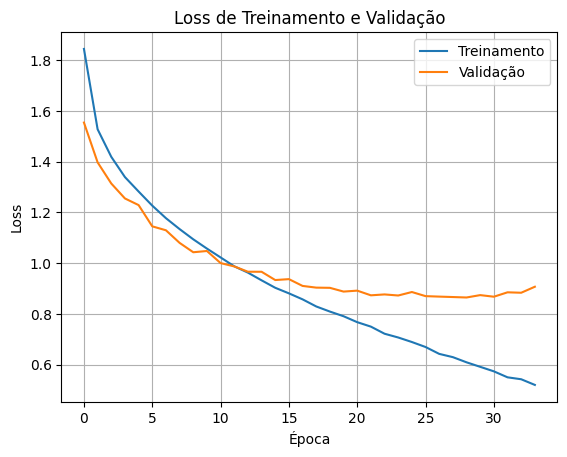

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.6932, 'balanced_accuracy': 0.6931999999999999, 'precision': 0.6954373416965544, 'recall': 0.6932, 'f1_score': 0.6913819540778005}


## Experiment: aumentar uma camada convolucional

In [ ]:
learning_rate = 0.0001
num_epochs = 50
batch_size = 32
patience = 5

train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [ ]:
config3 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1),
        (120, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.2),
        (84, 0.2)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
model_3_conv_layers = FlexibleCNN(config3).to(device)

optimizer = optim.Adam(model_3_conv_layers.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
trained_CNN, train_losses, val_losses = train_model(model_3_conv_layers,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:13<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.7091


  2%|▏         | 1/50 [00:20<16:52, 20.66s/it]

Epoch 1 completed. Train Loss: 1.8899 | Val Loss: 1.6140


  2%|▏         | 1/50 [00:34<16:52, 20.66s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.5430


  4%|▍         | 2/50 [00:41<16:30, 20.64s/it]

Epoch 2 completed. Train Loss: 1.6020 | Val Loss: 1.4849


  4%|▍         | 2/50 [00:55<16:30, 20.64s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.4012


  6%|▌         | 3/50 [01:01<16:03, 20.51s/it]

Epoch 3 completed. Train Loss: 1.4830 | Val Loss: 1.3699


  6%|▌         | 3/50 [01:13<16:03, 20.51s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.5262


  8%|▊         | 4/50 [01:18<14:37, 19.08s/it]

Epoch 4 completed. Train Loss: 1.4053 | Val Loss: 1.3012


  8%|▊         | 4/50 [01:29<14:37, 19.08s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.3053


 10%|█         | 5/50 [01:34<13:27, 17.95s/it]

Epoch 5 completed. Train Loss: 1.3331 | Val Loss: 1.2410


 10%|█         | 5/50 [01:45<13:27, 17.95s/it]

Epoch 6/50, Step 1000/1250, Loss: 1.2456


 12%|█▏        | 6/50 [01:50<12:46, 17.43s/it]

Epoch 6 completed. Train Loss: 1.2714 | Val Loss: 1.2078


 12%|█▏        | 6/50 [02:01<12:46, 17.43s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.0604


 14%|█▍        | 7/50 [02:07<12:11, 17.01s/it]

Epoch 7 completed. Train Loss: 1.2179 | Val Loss: 1.1392


 14%|█▍        | 7/50 [02:17<12:11, 17.01s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.8562


 16%|█▌        | 8/50 [02:23<11:40, 16.68s/it]

Epoch 8 completed. Train Loss: 1.1693 | Val Loss: 1.1094


 16%|█▌        | 8/50 [02:33<11:40, 16.68s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.2856


 18%|█▊        | 9/50 [02:38<11:12, 16.40s/it]

Epoch 9 completed. Train Loss: 1.1237 | Val Loss: 1.0700


 18%|█▊        | 9/50 [02:49<11:12, 16.40s/it]

Epoch 10/50, Step 1000/1250, Loss: 1.2547


 20%|██        | 10/50 [02:55<10:56, 16.41s/it]

Epoch 10 completed. Train Loss: 1.0839 | Val Loss: 1.0494


 20%|██        | 10/50 [03:06<10:56, 16.41s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.9705


 22%|██▏       | 11/50 [03:11<10:41, 16.45s/it]

Epoch 11 completed. Train Loss: 1.0375 | Val Loss: 1.0207


 22%|██▏       | 11/50 [03:22<10:41, 16.45s/it]

Epoch 12/50, Step 1000/1250, Loss: 1.2661


 24%|██▍       | 12/50 [03:28<10:26, 16.48s/it]

Epoch 12 completed. Train Loss: 1.0011 | Val Loss: 0.9799


 24%|██▍       | 12/50 [03:39<10:26, 16.48s/it]

Epoch 13/50, Step 1000/1250, Loss: 1.3518


 26%|██▌       | 13/50 [03:45<10:12, 16.56s/it]

Epoch 13 completed. Train Loss: 0.9638 | Val Loss: 0.9677


 26%|██▌       | 13/50 [03:56<10:12, 16.56s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.7915


 28%|██▊       | 14/50 [04:01<09:56, 16.56s/it]

Epoch 14 completed. Train Loss: 0.9346 | Val Loss: 0.9474


 28%|██▊       | 14/50 [04:12<09:56, 16.56s/it]

Epoch 15/50, Step 1000/1250, Loss: 1.0405


 30%|███       | 15/50 [04:18<09:40, 16.59s/it]

Epoch 15 completed. Train Loss: 0.9003 | Val Loss: 0.9211


 30%|███       | 15/50 [04:29<09:40, 16.59s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.9412


 32%|███▏      | 16/50 [04:34<09:23, 16.57s/it]

Epoch 16 completed. Train Loss: 0.8744 | Val Loss: 0.9010


 32%|███▏      | 16/50 [04:45<09:23, 16.57s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.6707


 34%|███▍      | 17/50 [04:51<09:07, 16.59s/it]

Epoch 17 completed. Train Loss: 0.8449 | Val Loss: 0.8989


 34%|███▍      | 17/50 [05:02<09:07, 16.59s/it]

Epoch 18/50, Step 1000/1250, Loss: 1.0410


 36%|███▌      | 18/50 [05:08<08:51, 16.61s/it]

Epoch 18 completed. Train Loss: 0.8180 | Val Loss: 0.8555


 36%|███▌      | 18/50 [05:19<08:51, 16.61s/it]

Epoch 19/50, Step 1000/1250, Loss: 0.7399


 38%|███▊      | 19/50 [05:25<08:39, 16.77s/it]

Epoch 19 completed. Train Loss: 0.7917 | Val Loss: 0.8642


 38%|███▊      | 19/50 [05:36<08:39, 16.77s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.6545


 40%|████      | 20/50 [05:41<08:22, 16.77s/it]

Epoch 20 completed. Train Loss: 0.7680 | Val Loss: 0.8740


 40%|████      | 20/50 [05:53<08:22, 16.77s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.6152


 42%|████▏     | 21/50 [05:58<08:05, 16.74s/it]

Epoch 21 completed. Train Loss: 0.7397 | Val Loss: 0.8392


 42%|████▏     | 21/50 [06:09<08:05, 16.74s/it]

Epoch 22/50, Step 1000/1250, Loss: 1.0784


 44%|████▍     | 22/50 [06:15<07:48, 16.73s/it]

Epoch 22 completed. Train Loss: 0.7194 | Val Loss: 0.8370


 44%|████▍     | 22/50 [06:26<07:48, 16.73s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.5248


 46%|████▌     | 23/50 [06:31<07:29, 16.64s/it]

Epoch 23 completed. Train Loss: 0.6986 | Val Loss: 0.8149


 46%|████▌     | 23/50 [06:42<07:29, 16.64s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.5122


 48%|████▊     | 24/50 [06:48<07:12, 16.62s/it]

Epoch 24 completed. Train Loss: 0.6746 | Val Loss: 0.8040


 48%|████▊     | 24/50 [06:59<07:12, 16.62s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.6586


 50%|█████     | 25/50 [07:04<06:53, 16.55s/it]

Epoch 25 completed. Train Loss: 0.6552 | Val Loss: 0.7944


 50%|█████     | 25/50 [07:15<06:53, 16.55s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.6592


 52%|█████▏    | 26/50 [07:21<06:36, 16.51s/it]

Epoch 26 completed. Train Loss: 0.6331 | Val Loss: 0.7948


 52%|█████▏    | 26/50 [07:32<06:36, 16.51s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.5694


 54%|█████▍    | 27/50 [07:37<06:18, 16.44s/it]

Epoch 27 completed. Train Loss: 0.6170 | Val Loss: 0.8086


 54%|█████▍    | 27/50 [07:48<06:18, 16.44s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.6380


 56%|█████▌    | 28/50 [07:53<06:00, 16.38s/it]

Epoch 28 completed. Train Loss: 0.5916 | Val Loss: 0.7839


 56%|█████▌    | 28/50 [08:04<06:00, 16.38s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.3366


 58%|█████▊    | 29/50 [08:10<05:44, 16.43s/it]

Epoch 29 completed. Train Loss: 0.5753 | Val Loss: 0.7943


 58%|█████▊    | 29/50 [08:21<05:44, 16.43s/it]

Epoch 30/50, Step 1000/1250, Loss: 0.6386


 60%|██████    | 30/50 [08:26<05:28, 16.40s/it]

Epoch 30 completed. Train Loss: 0.5513 | Val Loss: 0.8005


 60%|██████    | 30/50 [08:37<05:28, 16.40s/it]

Epoch 31/50, Step 1000/1250, Loss: 0.7213


 62%|██████▏   | 31/50 [08:43<05:11, 16.42s/it]

Epoch 31 completed. Train Loss: 0.5369 | Val Loss: 0.7994


 62%|██████▏   | 31/50 [08:54<05:11, 16.42s/it]

Epoch 32/50, Step 1000/1250, Loss: 0.5908


 64%|██████▍   | 32/50 [08:59<04:56, 16.45s/it]

Epoch 32 completed. Train Loss: 0.5158 | Val Loss: 0.8166


 64%|██████▍   | 32/50 [09:10<04:56, 16.45s/it]

Epoch 33/50, Step 1000/1250, Loss: 0.3090


 64%|██████▍   | 32/50 [09:16<05:12, 17.38s/it]

Epoch 33 completed. Train Loss: 0.4972 | Val Loss: 0.8023
Early stopping at epoch 33


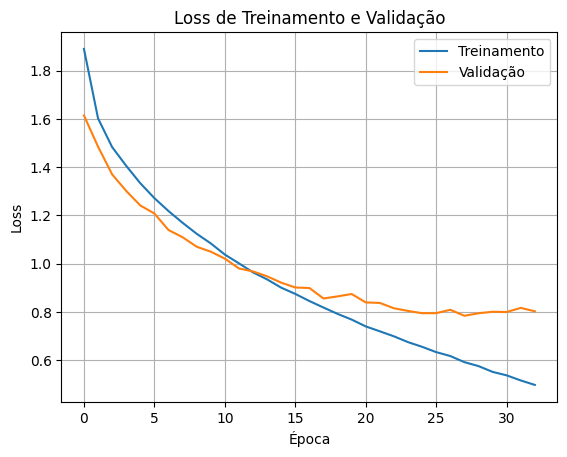

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model_3_conv_layers, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.74, 'balanced_accuracy': 0.74, 'precision': 0.7440000099510472, 'recall': 0.74, 'f1_score': 0.7406544420257327}


## Experiment: aumentar uma camada totalmente conectada

In [ ]:
config4 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1),
        (120, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (256, 0.2),
        (128, 0.2),
        (64, 0.2)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
model_3_conv_layers2 = FlexibleCNN(config4).to(device)

optimizer = optim.Adam(model_3_conv_layers2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
trained_CNN, train_losses, val_losses = train_model(model_3_conv_layers2,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [00:11<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.7869


  2%|▏         | 1/50 [00:16<13:35, 16.65s/it]

Epoch 1 completed. Train Loss: 1.8989 | Val Loss: 1.6320


  2%|▏         | 1/50 [00:28<13:35, 16.65s/it]

Epoch 2/50, Step 1000/1250, Loss: 1.4874


  4%|▍         | 2/50 [00:33<13:26, 16.81s/it]

Epoch 2 completed. Train Loss: 1.6137 | Val Loss: 1.4807


  4%|▍         | 2/50 [00:44<13:26, 16.81s/it]

Epoch 3/50, Step 1000/1250, Loss: 1.6888


  6%|▌         | 3/50 [00:50<13:05, 16.72s/it]

Epoch 3 completed. Train Loss: 1.4910 | Val Loss: 1.3830


  6%|▌         | 3/50 [01:01<13:05, 16.72s/it]

Epoch 4/50, Step 1000/1250, Loss: 1.4324


  8%|▊         | 4/50 [01:07<12:51, 16.77s/it]

Epoch 4 completed. Train Loss: 1.4053 | Val Loss: 1.3047


  8%|▊         | 4/50 [01:18<12:51, 16.77s/it]

Epoch 5/50, Step 1000/1250, Loss: 1.2852


 10%|█         | 5/50 [01:23<12:31, 16.71s/it]

Epoch 5 completed. Train Loss: 1.3360 | Val Loss: 1.2524


 10%|█         | 5/50 [01:34<12:31, 16.71s/it]

Epoch 6/50, Step 1000/1250, Loss: 1.4261


 12%|█▏        | 6/50 [01:40<12:15, 16.72s/it]

Epoch 6 completed. Train Loss: 1.2735 | Val Loss: 1.1873


 12%|█▏        | 6/50 [01:52<12:15, 16.72s/it]

Epoch 7/50, Step 1000/1250, Loss: 1.0912


 14%|█▍        | 7/50 [01:58<12:13, 17.05s/it]

Epoch 7 completed. Train Loss: 1.2118 | Val Loss: 1.1435


 14%|█▍        | 7/50 [02:10<12:13, 17.05s/it]

Epoch 8/50, Step 1000/1250, Loss: 1.1007


 16%|█▌        | 8/50 [02:15<12:06, 17.29s/it]

Epoch 8 completed. Train Loss: 1.1559 | Val Loss: 1.0992


 16%|█▌        | 8/50 [02:27<12:06, 17.29s/it]

Epoch 9/50, Step 1000/1250, Loss: 1.2391


 18%|█▊        | 9/50 [02:32<11:44, 17.17s/it]

Epoch 9 completed. Train Loss: 1.0997 | Val Loss: 1.0404


 18%|█▊        | 9/50 [02:44<11:44, 17.17s/it]

Epoch 10/50, Step 1000/1250, Loss: 0.7315


 20%|██        | 10/50 [02:50<11:30, 17.27s/it]

Epoch 10 completed. Train Loss: 1.0483 | Val Loss: 1.0023


 20%|██        | 10/50 [03:02<11:30, 17.27s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.8656


 22%|██▏       | 11/50 [03:08<11:20, 17.45s/it]

Epoch 11 completed. Train Loss: 1.0025 | Val Loss: 0.9655


 22%|██▏       | 11/50 [03:20<11:20, 17.45s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.7847


 24%|██▍       | 12/50 [03:26<11:08, 17.60s/it]

Epoch 12 completed. Train Loss: 0.9546 | Val Loss: 0.9433


 24%|██▍       | 12/50 [03:37<11:08, 17.60s/it]

Epoch 13/50, Step 1000/1250, Loss: 1.0278


 26%|██▌       | 13/50 [03:43<10:49, 17.55s/it]

Epoch 13 completed. Train Loss: 0.9160 | Val Loss: 0.9051


 26%|██▌       | 13/50 [03:55<10:49, 17.55s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.6643


 28%|██▊       | 14/50 [04:01<10:32, 17.57s/it]

Epoch 14 completed. Train Loss: 0.8787 | Val Loss: 0.9185


 28%|██▊       | 14/50 [04:13<10:32, 17.57s/it]

Epoch 15/50, Step 1000/1250, Loss: 0.8117


 30%|███       | 15/50 [04:18<10:16, 17.60s/it]

Epoch 15 completed. Train Loss: 0.8417 | Val Loss: 0.8712


 30%|███       | 15/50 [04:30<10:16, 17.60s/it]

Epoch 16/50, Step 1000/1250, Loss: 0.7443


 32%|███▏      | 16/50 [04:36<09:56, 17.54s/it]

Epoch 16 completed. Train Loss: 0.8099 | Val Loss: 0.8444


 32%|███▏      | 16/50 [04:47<09:56, 17.54s/it]

Epoch 17/50, Step 1000/1250, Loss: 0.5915


 34%|███▍      | 17/50 [04:53<09:37, 17.49s/it]

Epoch 17 completed. Train Loss: 0.7739 | Val Loss: 0.8296


 34%|███▍      | 17/50 [05:05<09:37, 17.49s/it]

Epoch 18/50, Step 1000/1250, Loss: 0.8256


 36%|███▌      | 18/50 [05:11<09:19, 17.47s/it]

Epoch 18 completed. Train Loss: 0.7498 | Val Loss: 0.8362


 36%|███▌      | 18/50 [05:22<09:19, 17.47s/it]

Epoch 19/50, Step 1000/1250, Loss: 1.1095


 38%|███▊      | 19/50 [05:28<09:00, 17.44s/it]

Epoch 19 completed. Train Loss: 0.7152 | Val Loss: 0.8161


 38%|███▊      | 19/50 [05:40<09:00, 17.44s/it]

Epoch 20/50, Step 1000/1250, Loss: 0.4588


 40%|████      | 20/50 [05:45<08:41, 17.39s/it]

Epoch 20 completed. Train Loss: 0.6868 | Val Loss: 0.8050


 40%|████      | 20/50 [05:57<08:41, 17.39s/it]

Epoch 21/50, Step 1000/1250, Loss: 0.4677


 42%|████▏     | 21/50 [06:03<08:24, 17.40s/it]

Epoch 21 completed. Train Loss: 0.6560 | Val Loss: 0.8123


 42%|████▏     | 21/50 [06:14<08:24, 17.40s/it]

Epoch 22/50, Step 1000/1250, Loss: 1.0388


 44%|████▍     | 22/50 [06:20<08:04, 17.32s/it]

Epoch 22 completed. Train Loss: 0.6262 | Val Loss: 0.8132


 44%|████▍     | 22/50 [06:31<08:04, 17.32s/it]

Epoch 23/50, Step 1000/1250, Loss: 0.8154


 46%|████▌     | 23/50 [06:37<07:46, 17.30s/it]

Epoch 23 completed. Train Loss: 0.5965 | Val Loss: 0.8058


 46%|████▌     | 23/50 [06:49<07:46, 17.30s/it]

Epoch 24/50, Step 1000/1250, Loss: 0.6967


 48%|████▊     | 24/50 [06:54<07:29, 17.30s/it]

Epoch 24 completed. Train Loss: 0.5713 | Val Loss: 0.7985


 48%|████▊     | 24/50 [07:06<07:29, 17.30s/it]

Epoch 25/50, Step 1000/1250, Loss: 0.8588


 50%|█████     | 25/50 [07:12<07:12, 17.31s/it]

Epoch 25 completed. Train Loss: 0.5480 | Val Loss: 0.8158


 50%|█████     | 25/50 [07:23<07:12, 17.31s/it]

Epoch 26/50, Step 1000/1250, Loss: 0.4617


 52%|█████▏    | 26/50 [07:29<06:55, 17.31s/it]

Epoch 26 completed. Train Loss: 0.5189 | Val Loss: 0.7933


 52%|█████▏    | 26/50 [07:40<06:55, 17.31s/it]

Epoch 27/50, Step 1000/1250, Loss: 0.2579


 54%|█████▍    | 27/50 [07:46<06:37, 17.27s/it]

Epoch 27 completed. Train Loss: 0.4928 | Val Loss: 0.8228


 54%|█████▍    | 27/50 [07:58<06:37, 17.27s/it]

Epoch 28/50, Step 1000/1250, Loss: 0.3874


 56%|█████▌    | 28/50 [08:03<06:20, 17.27s/it]

Epoch 28 completed. Train Loss: 0.4706 | Val Loss: 0.8102


 56%|█████▌    | 28/50 [08:15<06:20, 17.27s/it]

Epoch 29/50, Step 1000/1250, Loss: 0.6146


 58%|█████▊    | 29/50 [08:21<06:02, 17.25s/it]

Epoch 29 completed. Train Loss: 0.4488 | Val Loss: 0.8058


 58%|█████▊    | 29/50 [08:32<06:02, 17.25s/it]

Epoch 30/50, Step 1000/1250, Loss: 0.4204


 60%|██████    | 30/50 [08:38<05:44, 17.25s/it]

Epoch 30 completed. Train Loss: 0.4215 | Val Loss: 0.8142


 60%|██████    | 30/50 [08:49<05:44, 17.25s/it]

Epoch 31/50, Step 1000/1250, Loss: 0.3517


 60%|██████    | 30/50 [08:55<05:57, 17.86s/it]

Epoch 31 completed. Train Loss: 0.3949 | Val Loss: 0.8989
Early stopping at epoch 31


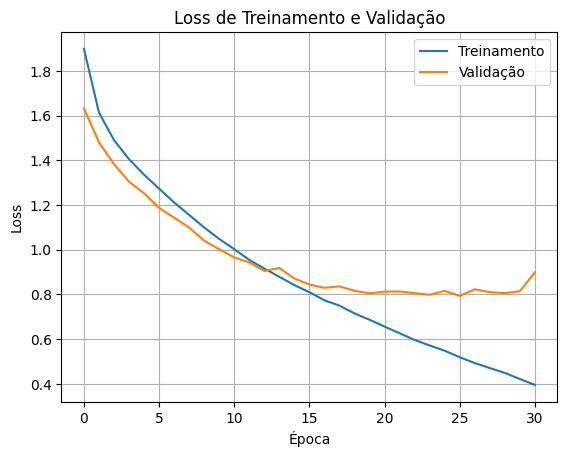

In [ ]:
plotLoss(train_losses, val_losses)

In [ ]:
labels, predictions = makePredictions(model_3_conv_layers2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.727, 'balanced_accuracy': 0.7269999999999999, 'precision': 0.7367266834219764, 'recall': 0.727, 'f1_score': 0.7276943242436139}


# Experimento - Mudança no Kernel da Segunda Camada Convolucional

In [15]:
learning_rate = 0.001
num_epochs = 1000
batch_size = 32
patience = 5

In [19]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [17]:
configKernel = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 5, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
modelKernel = FlexibleCNN(configKernel).to(device)

optimizer = optim.Adam(modelKernel.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [20]:
trained_CNN, train_losses, val_losses = train_model(modelKernel,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/1000 [00:11<?, ?it/s]

Epoch 1/1000, Step 1000/1250, Loss: 1.1826


  0%|          | 1/1000 [00:16<4:41:03, 16.88s/it]

Epoch 1 completed. Train Loss: 1.4162 | Val Loss: 1.1598


  0%|          | 1/1000 [00:27<4:41:03, 16.88s/it]

Epoch 2/1000, Step 1000/1250, Loss: 0.8898


  0%|          | 2/1000 [00:32<4:24:41, 15.91s/it]

Epoch 2 completed. Train Loss: 1.0189 | Val Loss: 0.9414


  0%|          | 2/1000 [00:43<4:24:41, 15.91s/it]

Epoch 3/1000, Step 1000/1250, Loss: 0.6269


  0%|          | 3/1000 [00:48<4:24:32, 15.92s/it]

Epoch 3 completed. Train Loss: 0.8417 | Val Loss: 0.8821


  0%|          | 3/1000 [00:58<4:24:32, 15.92s/it]

Epoch 4/1000, Step 1000/1250, Loss: 0.6784


  0%|          | 4/1000 [01:03<4:24:20, 15.92s/it]

Epoch 4 completed. Train Loss: 0.7279 | Val Loss: 0.8737


  0%|          | 4/1000 [01:14<4:24:20, 15.92s/it]

Epoch 5/1000, Step 1000/1250, Loss: 0.4973


  0%|          | 5/1000 [01:20<4:25:09, 15.99s/it]

Epoch 5 completed. Train Loss: 0.6302 | Val Loss: 0.8515


  0%|          | 5/1000 [01:30<4:25:09, 15.99s/it]

Epoch 6/1000, Step 1000/1250, Loss: 0.6513


  1%|          | 6/1000 [01:35<4:22:30, 15.85s/it]

Epoch 6 completed. Train Loss: 0.5485 | Val Loss: 0.8879


  1%|          | 6/1000 [01:46<4:22:30, 15.85s/it]

Epoch 7/1000, Step 1000/1250, Loss: 0.6000


  1%|          | 7/1000 [01:51<4:23:26, 15.92s/it]

Epoch 7 completed. Train Loss: 0.4728 | Val Loss: 0.8958


  1%|          | 7/1000 [02:01<4:23:26, 15.92s/it]

Epoch 8/1000, Step 1000/1250, Loss: 0.2954


  1%|          | 8/1000 [02:07<4:24:15, 15.98s/it]

Epoch 8 completed. Train Loss: 0.4045 | Val Loss: 0.9678


  1%|          | 8/1000 [02:18<4:24:15, 15.98s/it]

Epoch 9/1000, Step 1000/1250, Loss: 0.4157


  1%|          | 9/1000 [02:23<4:21:42, 15.84s/it]

Epoch 9 completed. Train Loss: 0.3433 | Val Loss: 1.0345


  1%|          | 9/1000 [02:33<4:21:42, 15.84s/it]

Epoch 10/1000, Step 1000/1250, Loss: 0.3334


  1%|          | 9/1000 [02:39<4:52:48, 17.73s/it]

Epoch 10 completed. Train Loss: 0.2952 | Val Loss: 1.1620
Early stopping at epoch 10


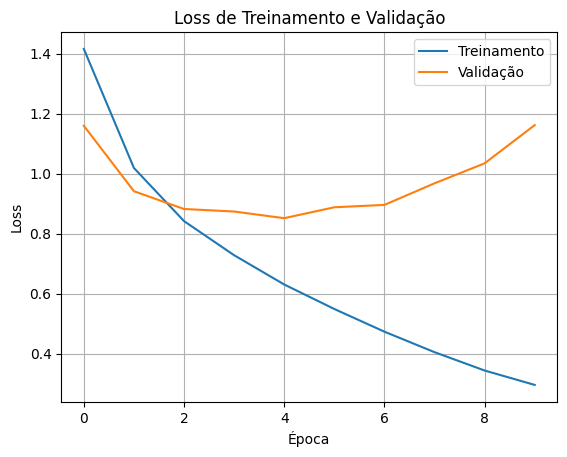

In [21]:
plotLoss(train_losses, val_losses)

In [22]:
labels, predictions = makePredictions(modelKernel, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.7094, 'balanced_accuracy': np.float64(0.7093999999999999), 'precision': 0.7128557065524792, 'recall': 0.7094, 'f1_score': 0.7077945194460905}


# Experimento - Batch Normalization

Redefinição da classe FlexibleCNN:

In [18]:
class FlexibleCNNBatch(nn.Module):

    def __init__(self, config):
        super(FlexibleCNNBatch, self).__init__()
        self.config = config

        initial_in_channels = 3
        img_height, img_width = 32, 32

        # 1. Construindo as camadas de features
        features_layers = []
        in_channels = initial_in_channels

        for out_channels, k, s, p in self.config['conv_layers']:
            # Convolução
            features_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=k, stride=s, padding=p)
            )
            # Batch Normalization
            features_layers.append(
                nn.BatchNorm2d(out_channels)
            )
            # Ativação
            features_layers.append(nn.ReLU(inplace=True))

            # Pooling, se configurado
            if self.config.get('pool_kernel_size'):
                features_layers.append(
                    nn.MaxPool2d(
                        kernel_size=self.config['pool_kernel_size'],
                        stride=self.config.get('pool_stride', self.config['pool_kernel_size'])
                    )
                )

            in_channels = out_channels

        self.features = nn.Sequential(*features_layers)

        # 2. Determinar tamanho do flatten
        with torch.no_grad():
            dummy = torch.zeros(1, initial_in_channels, img_height, img_width)
            flat_size = self.features(dummy).view(1, -1).size(1)
            self.flattened_features_size = flat_size

        # 3. Construindo o classificador
        classifier_layers = []
        in_features = self.flattened_features_size

        for out_features, dropout_rate in self.config.get('fc_layers', []):
            classifier_layers.append(nn.Linear(in_features, out_features))
            # Se você quiser BatchNorm nas camadas lineares, use nn.BatchNorm1d(out_features) aqui
            classifier_layers.append(nn.ReLU(inplace=True))
            if dropout_rate > 0:
                classifier_layers.append(nn.Dropout(p=dropout_rate))
            in_features = out_features

        classifier_layers.append(nn.Linear(in_features, self.config['output_size']))
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [40]:
learning_rate = 0.001
num_epochs = 1000
batch_size = 32
patience = 5

In [41]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [42]:
configBatch = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1)
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
modelBatch = FlexibleCNNBatch(configBatch).to(device)

optimizer = optim.Adam(modelBatch.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [43]:
trained_CNN, train_losses, val_losses = train_model(modelBatch,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/1000 [00:10<?, ?it/s]

Epoch 1/1000, Step 1000/1250, Loss: 1.0754


  0%|          | 1/1000 [00:15<4:18:34, 15.53s/it]

Epoch 1 completed. Train Loss: 1.3017 | Val Loss: 1.0420


  0%|          | 1/1000 [00:25<4:18:34, 15.53s/it]

Epoch 2/1000, Step 1000/1250, Loss: 1.0941


  0%|          | 2/1000 [00:30<4:13:17, 15.23s/it]

Epoch 2 completed. Train Loss: 0.9641 | Val Loss: 0.9061


  0%|          | 2/1000 [00:40<4:13:17, 15.23s/it]

Epoch 3/1000, Step 1000/1250, Loss: 0.8470


  0%|          | 3/1000 [00:45<4:10:48, 15.09s/it]

Epoch 3 completed. Train Loss: 0.8394 | Val Loss: 0.8769


  0%|          | 3/1000 [00:55<4:10:48, 15.09s/it]

Epoch 4/1000, Step 1000/1250, Loss: 0.9216


  0%|          | 4/1000 [01:00<4:12:00, 15.18s/it]

Epoch 4 completed. Train Loss: 0.7527 | Val Loss: 0.8976


  0%|          | 4/1000 [01:10<4:12:00, 15.18s/it]

Epoch 5/1000, Step 1000/1250, Loss: 0.6809


  0%|          | 5/1000 [01:16<4:12:38, 15.23s/it]

Epoch 5 completed. Train Loss: 0.6757 | Val Loss: 0.8252


  0%|          | 5/1000 [01:26<4:12:38, 15.23s/it]

Epoch 6/1000, Step 1000/1250, Loss: 1.0583


  1%|          | 6/1000 [01:31<4:14:12, 15.34s/it]

Epoch 6 completed. Train Loss: 0.6074 | Val Loss: 0.7996


  1%|          | 6/1000 [01:41<4:14:12, 15.34s/it]

Epoch 7/1000, Step 1000/1250, Loss: 0.6794


  1%|          | 7/1000 [01:46<4:11:23, 15.19s/it]

Epoch 7 completed. Train Loss: 0.5459 | Val Loss: 0.8536


  1%|          | 7/1000 [01:56<4:11:23, 15.19s/it]

Epoch 8/1000, Step 1000/1250, Loss: 0.4042


  1%|          | 8/1000 [02:01<4:11:16, 15.20s/it]

Epoch 8 completed. Train Loss: 0.4859 | Val Loss: 0.9361


  1%|          | 8/1000 [02:14<4:11:16, 15.20s/it]

Epoch 9/1000, Step 1000/1250, Loss: 0.3921


  1%|          | 9/1000 [02:19<4:21:55, 15.86s/it]

Epoch 9 completed. Train Loss: 0.4370 | Val Loss: 0.8713


  1%|          | 9/1000 [02:29<4:21:55, 15.86s/it]

Epoch 10/1000, Step 1000/1250, Loss: 0.1201


  1%|          | 10/1000 [02:33<4:15:33, 15.49s/it]

Epoch 10 completed. Train Loss: 0.3874 | Val Loss: 0.9231


  1%|          | 10/1000 [02:43<4:15:33, 15.49s/it]

Epoch 11/1000, Step 1000/1250, Loss: 0.2372


  1%|          | 10/1000 [02:48<4:38:08, 16.86s/it]

Epoch 11 completed. Train Loss: 0.3436 | Val Loss: 1.0090
Early stopping at epoch 11


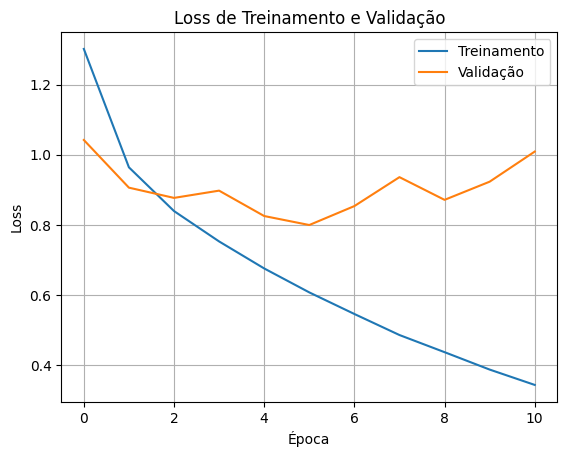

In [44]:
plotLoss(train_losses, val_losses)

In [45]:
labels, predictions = makePredictions(modelBatch, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.7199, 'balanced_accuracy': np.float64(0.7199), 'precision': 0.7296047684067088, 'recall': 0.7199, 'f1_score': 0.7195202480305174}


# Experimento - Batch Normalization + Menor Learning Rate e Maior Patience

In [19]:
learning_rate = 0.0001
num_epochs = 1000
batch_size = 32
patience = 10

In [20]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [21]:
configBatch2 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1),
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
modelBatch2 = FlexibleCNNBatch(configBatch2).to(device)

optimizer = optim.Adam(modelBatch2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [50]:
trained_CNN, train_losses, val_losses = train_model(modelBatch2,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/1000 [00:10<?, ?it/s]

Epoch 1/1000, Step 1000/1250, Loss: 1.1496


  0%|          | 1/1000 [00:20<5:40:42, 20.46s/it]

Epoch 1 completed. Train Loss: 1.4139 | Val Loss: 1.1695


  0%|          | 1/1000 [00:36<5:40:42, 20.46s/it]

Epoch 2/1000, Step 1000/1250, Loss: 0.9961


  0%|          | 2/1000 [00:41<5:45:35, 20.78s/it]

Epoch 2 completed. Train Loss: 1.0716 | Val Loss: 1.0136


  0%|          | 2/1000 [00:51<5:45:35, 20.78s/it]

Epoch 3/1000, Step 1000/1250, Loss: 0.9639


  0%|          | 3/1000 [00:57<5:07:04, 18.48s/it]

Epoch 3 completed. Train Loss: 0.9535 | Val Loss: 0.9927


  0%|          | 3/1000 [01:06<5:07:04, 18.48s/it]

Epoch 4/1000, Step 1000/1250, Loss: 0.4946


  0%|          | 4/1000 [01:12<4:42:47, 17.04s/it]

Epoch 4 completed. Train Loss: 0.8803 | Val Loss: 0.9299


  0%|          | 4/1000 [01:22<4:42:47, 17.04s/it]

Epoch 5/1000, Step 1000/1250, Loss: 0.6605


  0%|          | 5/1000 [01:27<4:32:53, 16.46s/it]

Epoch 5 completed. Train Loss: 0.8151 | Val Loss: 0.9016


  0%|          | 5/1000 [01:37<4:32:53, 16.46s/it]

Epoch 6/1000, Step 1000/1250, Loss: 0.7651


  1%|          | 6/1000 [01:42<4:23:03, 15.88s/it]

Epoch 6 completed. Train Loss: 0.7669 | Val Loss: 0.8824


  1%|          | 6/1000 [01:52<4:23:03, 15.88s/it]

Epoch 7/1000, Step 1000/1250, Loss: 0.8491


  1%|          | 7/1000 [01:57<4:20:52, 15.76s/it]

Epoch 7 completed. Train Loss: 0.7191 | Val Loss: 0.8973


  1%|          | 7/1000 [02:07<4:20:52, 15.76s/it]

Epoch 8/1000, Step 1000/1250, Loss: 1.0215


  1%|          | 8/1000 [02:12<4:14:55, 15.42s/it]

Epoch 8 completed. Train Loss: 0.6745 | Val Loss: 0.8564


  1%|          | 8/1000 [02:22<4:14:55, 15.42s/it]

Epoch 9/1000, Step 1000/1250, Loss: 0.8042


  1%|          | 9/1000 [02:27<4:11:57, 15.25s/it]

Epoch 9 completed. Train Loss: 0.6383 | Val Loss: 0.8359


  1%|          | 9/1000 [02:37<4:11:57, 15.25s/it]

Epoch 10/1000, Step 1000/1250, Loss: 0.4293


  1%|          | 10/1000 [02:42<4:08:53, 15.08s/it]

Epoch 10 completed. Train Loss: 0.5986 | Val Loss: 0.8300


  1%|          | 10/1000 [02:52<4:08:53, 15.08s/it]

Epoch 11/1000, Step 1000/1250, Loss: 0.2969


  1%|          | 11/1000 [02:57<4:10:00, 15.17s/it]

Epoch 11 completed. Train Loss: 0.5560 | Val Loss: 0.8608


  1%|          | 11/1000 [03:07<4:10:00, 15.17s/it]

Epoch 12/1000, Step 1000/1250, Loss: 0.6484


  1%|          | 12/1000 [03:12<4:09:36, 15.16s/it]

Epoch 12 completed. Train Loss: 0.5272 | Val Loss: 0.8337


  1%|          | 12/1000 [03:22<4:09:36, 15.16s/it]

Epoch 13/1000, Step 1000/1250, Loss: 0.5353


  1%|▏         | 13/1000 [03:27<4:07:05, 15.02s/it]

Epoch 13 completed. Train Loss: 0.4889 | Val Loss: 0.8486


  1%|▏         | 13/1000 [03:37<4:07:05, 15.02s/it]

Epoch 14/1000, Step 1000/1250, Loss: 0.6420


  1%|▏         | 14/1000 [03:41<4:05:40, 14.95s/it]

Epoch 14 completed. Train Loss: 0.4590 | Val Loss: 0.8607


  1%|▏         | 14/1000 [03:52<4:05:40, 14.95s/it]

Epoch 15/1000, Step 1000/1250, Loss: 0.3765


  2%|▏         | 15/1000 [03:57<4:06:47, 15.03s/it]

Epoch 15 completed. Train Loss: 0.4269 | Val Loss: 0.9446


  2%|▏         | 15/1000 [04:06<4:06:47, 15.03s/it]

Epoch 16/1000, Step 1000/1250, Loss: 0.3338


  2%|▏         | 16/1000 [04:12<4:06:14, 15.01s/it]

Epoch 16 completed. Train Loss: 0.3993 | Val Loss: 0.8925


  2%|▏         | 16/1000 [04:22<4:06:14, 15.01s/it]

Epoch 17/1000, Step 1000/1250, Loss: 0.3969


  2%|▏         | 17/1000 [04:26<4:04:53, 14.95s/it]

Epoch 17 completed. Train Loss: 0.3691 | Val Loss: 0.9264


  2%|▏         | 17/1000 [04:37<4:04:53, 14.95s/it]

Epoch 18/1000, Step 1000/1250, Loss: 0.5339


  2%|▏         | 18/1000 [04:41<4:03:16, 14.86s/it]

Epoch 18 completed. Train Loss: 0.3430 | Val Loss: 0.9095


  2%|▏         | 18/1000 [04:51<4:03:16, 14.86s/it]

Epoch 19/1000, Step 1000/1250, Loss: 0.4661


  2%|▏         | 19/1000 [04:57<4:06:50, 15.10s/it]

Epoch 19 completed. Train Loss: 0.3182 | Val Loss: 0.9888


  2%|▏         | 19/1000 [05:07<4:06:50, 15.10s/it]

Epoch 20/1000, Step 1000/1250, Loss: 0.3030


  2%|▏         | 19/1000 [05:12<4:28:48, 16.44s/it]

Epoch 20 completed. Train Loss: 0.2888 | Val Loss: 1.0051
Early stopping at epoch 20


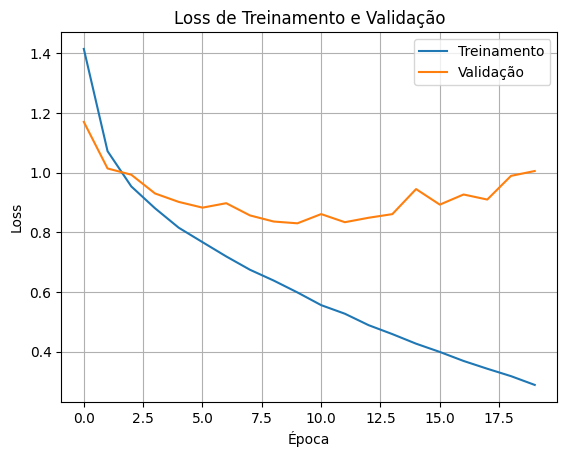

In [51]:
plotLoss(train_losses, val_losses)

In [52]:
labels, predictions = makePredictions(modelBatch2, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.711, 'balanced_accuracy': np.float64(0.711), 'precision': 0.7148923113421394, 'recall': 0.711, 'f1_score': 0.7090700034102567}


# Experimento - Batch Normalization + profundas

In [22]:
learning_rate = 0.0001
num_epochs = 1000
batch_size = 32
patience = 10

In [23]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [24]:
configBatch3 = {
    'conv_layers': [
        (32, 3, 1, 1),
        (64, 3, 1, 1),
        (64, 3, 1, 1),
        (64, 3, 1, 1),
    ],
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'fc_layers': [
        (120, 0.0),
        (84, 0.0)
    ],
    'output_size': 10
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criando o modelo
modelBatch3 = FlexibleCNNBatch(configBatch3).to(device)

optimizer = optim.Adam(modelBatch3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [25]:
trained_CNN, train_losses, val_losses = train_model(modelBatch3,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/1000 [00:12<?, ?it/s]

Epoch 1/1000, Step 1000/1250, Loss: 1.3363


  0%|          | 1/1000 [00:18<5:06:27, 18.41s/it]

Epoch 1 completed. Train Loss: 1.4584 | Val Loss: 1.1591


  0%|          | 1/1000 [00:29<5:06:27, 18.41s/it]

Epoch 2/1000, Step 1000/1250, Loss: 0.9187


  0%|          | 2/1000 [00:34<4:45:50, 17.18s/it]

Epoch 2 completed. Train Loss: 1.0285 | Val Loss: 0.9872


  0%|          | 2/1000 [00:45<4:45:50, 17.18s/it]

Epoch 3/1000, Step 1000/1250, Loss: 0.7983


  0%|          | 3/1000 [00:51<4:39:19, 16.81s/it]

Epoch 3 completed. Train Loss: 0.8836 | Val Loss: 0.9392


  0%|          | 3/1000 [01:02<4:39:19, 16.81s/it]

Epoch 4/1000, Step 1000/1250, Loss: 0.7991


  0%|          | 4/1000 [01:08<4:40:00, 16.87s/it]

Epoch 4 completed. Train Loss: 0.7855 | Val Loss: 0.8492


  0%|          | 4/1000 [01:19<4:40:00, 16.87s/it]

Epoch 5/1000, Step 1000/1250, Loss: 0.5195


  0%|          | 5/1000 [01:24<4:35:41, 16.62s/it]

Epoch 5 completed. Train Loss: 0.7137 | Val Loss: 0.8350


  0%|          | 5/1000 [01:35<4:35:41, 16.62s/it]

Epoch 6/1000, Step 1000/1250, Loss: 0.4577


  1%|          | 6/1000 [01:40<4:35:19, 16.62s/it]

Epoch 6 completed. Train Loss: 0.6452 | Val Loss: 0.8809


  1%|          | 6/1000 [01:51<4:35:19, 16.62s/it]

Epoch 7/1000, Step 1000/1250, Loss: 0.4900


  1%|          | 7/1000 [01:57<4:35:54, 16.67s/it]

Epoch 7 completed. Train Loss: 0.5908 | Val Loss: 0.8359


  1%|          | 7/1000 [02:08<4:35:54, 16.67s/it]

Epoch 8/1000, Step 1000/1250, Loss: 0.3337


  1%|          | 8/1000 [02:13<4:33:25, 16.54s/it]

Epoch 8 completed. Train Loss: 0.5400 | Val Loss: 0.8238


  1%|          | 8/1000 [02:25<4:33:25, 16.54s/it]

Epoch 9/1000, Step 1000/1250, Loss: 0.4340


  1%|          | 9/1000 [02:30<4:36:00, 16.71s/it]

Epoch 9 completed. Train Loss: 0.4961 | Val Loss: 0.8786


  1%|          | 9/1000 [02:41<4:36:00, 16.71s/it]

Epoch 10/1000, Step 1000/1250, Loss: 0.2040


  1%|          | 10/1000 [02:47<4:33:56, 16.60s/it]

Epoch 10 completed. Train Loss: 0.4499 | Val Loss: 0.9147


  1%|          | 10/1000 [02:58<4:33:56, 16.60s/it]

Epoch 11/1000, Step 1000/1250, Loss: 0.3524


  1%|          | 11/1000 [03:03<4:33:08, 16.57s/it]

Epoch 11 completed. Train Loss: 0.4125 | Val Loss: 0.8918


  1%|          | 11/1000 [03:15<4:33:08, 16.57s/it]

Epoch 12/1000, Step 1000/1250, Loss: 0.6649


  1%|          | 12/1000 [03:20<4:34:41, 16.68s/it]

Epoch 12 completed. Train Loss: 0.3773 | Val Loss: 0.9152


  1%|          | 12/1000 [03:32<4:34:41, 16.68s/it]

Epoch 13/1000, Step 1000/1250, Loss: 0.4587


  1%|▏         | 13/1000 [03:37<4:32:54, 16.59s/it]

Epoch 13 completed. Train Loss: 0.3401 | Val Loss: 0.9546


  1%|▏         | 13/1000 [03:48<4:32:54, 16.59s/it]

Epoch 14/1000, Step 1000/1250, Loss: 0.2998


  1%|▏         | 14/1000 [03:53<4:33:01, 16.61s/it]

Epoch 14 completed. Train Loss: 0.3128 | Val Loss: 0.9653


  1%|▏         | 14/1000 [04:05<4:33:01, 16.61s/it]

Epoch 15/1000, Step 1000/1250, Loss: 0.3492


  2%|▏         | 15/1000 [04:10<4:34:59, 16.75s/it]

Epoch 15 completed. Train Loss: 0.2842 | Val Loss: 0.9782


  2%|▏         | 15/1000 [04:22<4:34:59, 16.75s/it]

Epoch 16/1000, Step 1000/1250, Loss: 0.3993


  2%|▏         | 16/1000 [04:27<4:33:28, 16.68s/it]

Epoch 16 completed. Train Loss: 0.2567 | Val Loss: 1.0149


  2%|▏         | 16/1000 [04:38<4:33:28, 16.68s/it]

Epoch 17/1000, Step 1000/1250, Loss: 0.0397


  2%|▏         | 17/1000 [04:44<4:35:15, 16.80s/it]

Epoch 17 completed. Train Loss: 0.2315 | Val Loss: 1.0902


  2%|▏         | 17/1000 [04:55<4:35:15, 16.80s/it]

Epoch 18/1000, Step 1000/1250, Loss: 0.1437


  2%|▏         | 17/1000 [05:01<4:50:07, 17.71s/it]

Epoch 18 completed. Train Loss: 0.2112 | Val Loss: 1.1343
Early stopping at epoch 18


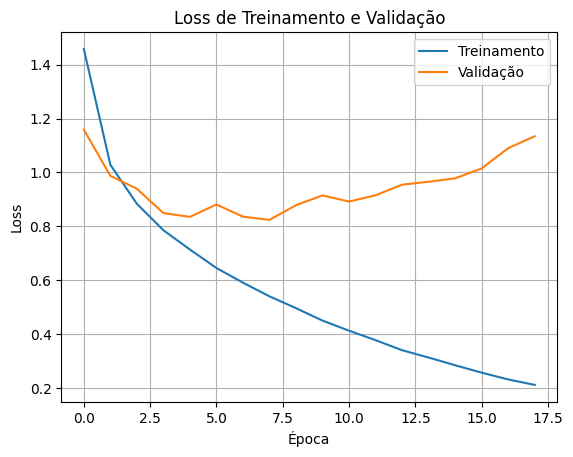

In [26]:
plotLoss(train_losses, val_losses)

In [27]:
labels, predictions = makePredictions(modelBatch3, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.7204, 'balanced_accuracy': np.float64(0.7204), 'precision': 0.7311908663323562, 'recall': 0.7204, 'f1_score': 0.7211768945636827}


# Experimento - ResNet (transfer learning)

## Congelamento de todas as camadas exceto a última.

In [49]:
from torchvision import models

In [50]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [51]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,  transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True,  transform=transform)

classes = test_dataset.classes

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # só a nova camada

In [54]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [55]:
def makeLoaders(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [56]:
learning_rate = 0.001
num_epochs = 50
batch_size = 32
patience = 5

In [57]:
train_loader, val_loader, test_loader = makeLoaders(batch_size)

In [59]:
trained_CNN, train_losses, val_losses = train_model(model,
                                                    train_loader,
                                                    val_loader,
                                                    criterion,
                                                    optimizer,
                                                    device,
                                                    num_epochs,
                                                    patience)

  0%|          | 0/50 [01:16<?, ?it/s]

Epoch 1/50, Step 1000/1250, Loss: 1.0139


  2%|▏         | 1/50 [01:59<1:37:18, 119.15s/it]

Epoch 1 completed. Train Loss: 0.7611 | Val Loss: 0.6149


  2%|▏         | 1/50 [03:14<1:37:18, 119.15s/it]

Epoch 2/50, Step 1000/1250, Loss: 0.4459


  4%|▍         | 2/50 [03:55<1:34:10, 117.71s/it]

Epoch 2 completed. Train Loss: 0.6479 | Val Loss: 0.5888


  4%|▍         | 2/50 [05:10<1:34:10, 117.71s/it]

Epoch 3/50, Step 1000/1250, Loss: 0.6545


  6%|▌         | 3/50 [05:53<1:32:04, 117.54s/it]

Epoch 3 completed. Train Loss: 0.6202 | Val Loss: 0.5849


  6%|▌         | 3/50 [07:07<1:32:04, 117.54s/it]

Epoch 4/50, Step 1000/1250, Loss: 0.5613


  8%|▊         | 4/50 [07:49<1:29:45, 117.09s/it]

Epoch 4 completed. Train Loss: 0.6104 | Val Loss: 0.5560


  8%|▊         | 4/50 [09:04<1:29:45, 117.09s/it]

Epoch 5/50, Step 1000/1250, Loss: 0.8064


 10%|█         | 5/50 [09:46<1:27:45, 117.02s/it]

Epoch 5 completed. Train Loss: 0.6055 | Val Loss: 0.5917


 10%|█         | 5/50 [11:01<1:27:45, 117.02s/it]

Epoch 6/50, Step 1000/1250, Loss: 0.6771


 12%|█▏        | 6/50 [11:42<1:25:35, 116.72s/it]

Epoch 6 completed. Train Loss: 0.5983 | Val Loss: 0.5741


 12%|█▏        | 6/50 [12:57<1:25:35, 116.72s/it]

Epoch 7/50, Step 1000/1250, Loss: 0.2954


 14%|█▍        | 7/50 [13:38<1:23:32, 116.58s/it]

Epoch 7 completed. Train Loss: 0.5931 | Val Loss: 0.5582


 14%|█▍        | 7/50 [14:54<1:23:32, 116.58s/it]

Epoch 8/50, Step 1000/1250, Loss: 0.3554


 16%|█▌        | 8/50 [15:35<1:21:41, 116.70s/it]

Epoch 8 completed. Train Loss: 0.5927 | Val Loss: 0.5580


 16%|█▌        | 8/50 [16:50<1:21:41, 116.70s/it]

Epoch 9/50, Step 1000/1250, Loss: 0.9512


 18%|█▊        | 9/50 [17:32<1:19:44, 116.69s/it]

Epoch 9 completed. Train Loss: 0.5874 | Val Loss: 0.5549


 18%|█▊        | 9/50 [18:53<1:19:44, 116.69s/it]

Epoch 10/50, Step 1000/1250, Loss: 0.3423


 20%|██        | 10/50 [19:35<1:19:05, 118.64s/it]

Epoch 10 completed. Train Loss: 0.5801 | Val Loss: 0.5593


 20%|██        | 10/50 [20:50<1:19:05, 118.64s/it]

Epoch 11/50, Step 1000/1250, Loss: 0.8027


 22%|██▏       | 11/50 [21:33<1:16:56, 118.36s/it]

Epoch 11 completed. Train Loss: 0.5768 | Val Loss: 0.5682


 22%|██▏       | 11/50 [22:47<1:16:56, 118.36s/it]

Epoch 12/50, Step 1000/1250, Loss: 0.5223


 24%|██▍       | 12/50 [23:29<1:14:38, 117.85s/it]

Epoch 12 completed. Train Loss: 0.5841 | Val Loss: 0.5619


 24%|██▍       | 12/50 [24:45<1:14:38, 117.85s/it]

Epoch 13/50, Step 1000/1250, Loss: 0.4756


 26%|██▌       | 13/50 [25:28<1:12:43, 117.93s/it]

Epoch 13 completed. Train Loss: 0.5793 | Val Loss: 0.5563


 26%|██▌       | 13/50 [26:43<1:12:43, 117.93s/it]

Epoch 14/50, Step 1000/1250, Loss: 0.8637


 26%|██▌       | 13/50 [27:26<1:18:04, 126.62s/it]

Epoch 14 completed. Train Loss: 0.5794 | Val Loss: 0.5615
Early stopping at epoch 14


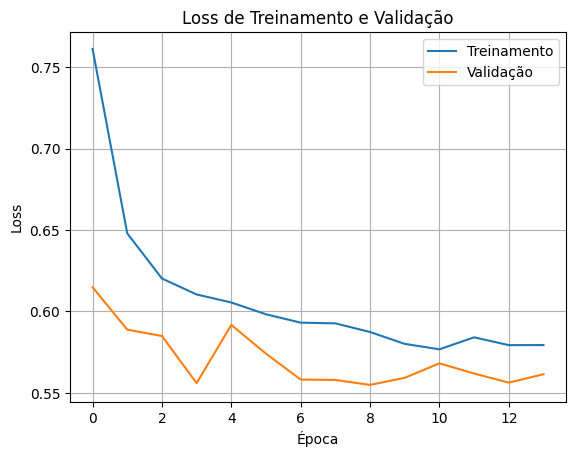

In [64]:
plotLoss(train_losses, val_losses)

In [66]:
labels, predictions = makePredictions(model, test_loader)

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.803, 'balanced_accuracy': np.float64(0.8029999999999999), 'precision': 0.8064069898691425, 'recall': 0.803, 'f1_score': 0.8028230147312068}


## Mostrar exemplos classificados corretamente e incorretamente

In [60]:
# Função para desnormalizar e exibir em um subplot (sem plt.show())
def imshow_subplot(ax, img_tensor, title=""):
    img = img_tensor.cpu().numpy()
    # Desnormaliza a imagem
    img = img / 2 + 0.5
    # Converte de (C, H, W) para (H, W, C) para o matplotlib
    img = np.transpose(img, (1, 2, 0))

    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

Encontradas 5 imagens corretas e 5 imagens incorretas.


NameError: name 'class_names' is not defined

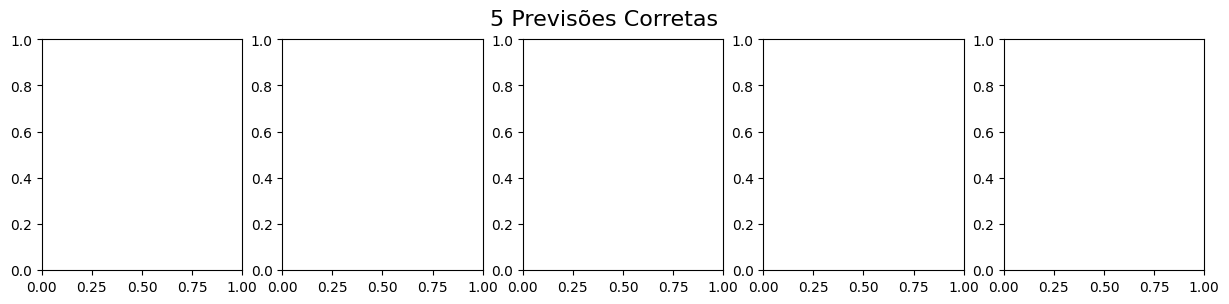

In [63]:
# Listas para armazenar os resultados
correct_images = []
correct_labels = []
incorrect_images = []
incorrect_true_labels = []
incorrect_pred_labels = []

model1.eval()

# Loop para encontrar as imagens
with torch.no_grad():
    # Itera sobre o loader de teste
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model1(images)
        _, preds = torch.max(outputs, 1)

        # Itera sobre o batch
        for i in range(len(labels)):
            if preds[i] == labels[i] and len(correct_images) < 5:
                correct_images.append(images[i].cpu())
                correct_labels.append(preds[i].cpu())

            # Se a previsão está incorreta E ainda não temos 5
            elif preds[i] != labels[i] and len(incorrect_images) < 5:
                incorrect_images.append(images[i].cpu())
                incorrect_true_labels.append(labels[i].cpu())
                incorrect_pred_labels.append(preds[i].cpu())

            # Condição de parada: para quando ambas as listas estiverem cheias
            if len(correct_images) == 5 and len(incorrect_images) == 5:
                break

        # Para o loop principal também
        if len(correct_images) == 5 and len(incorrect_images) == 5:
            break

print(f"Encontradas {len(correct_images)} imagens corretas e {len(incorrect_images)} imagens incorretas.")


# Exibe as 5 previsões corretas
fig_correct, axes_correct = plt.subplots(1, 5, figsize=(15, 3))
fig_correct.suptitle("5 Previsões Corretas", fontsize=16)

for i, ax in enumerate(axes_correct):
    if i < len(correct_images):
        title = f"Previsto:\n{class_names[correct_labels[i].item()]}"
        imshow_subplot(ax, correct_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajusta para o super-título
plt.show()


# Exibe as 5 previsões incorretas
fig_incorrect, axes_incorrect = plt.subplots(1, 5, figsize=(15, 4)) # Um pouco mais de altura para o título duplo
fig_incorrect.suptitle("5 Previsões Incorretas", fontsize=16)

for i, ax in enumerate(axes_incorrect):
    if i < len(incorrect_images):
        title = f"Previsto: {class_names[incorrect_pred_labels[i].item()]}\nReal: {class_names[incorrect_true_labels[i].item()]}"
        imshow_subplot(ax, incorrect_images[i], title)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()